In [ ]:

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")


In [47]:
data = pd.read_csv('../data/ola_updated.csv')
print(data.head())

   season  weather   temp  humidity  windspeed  casual  registered  count  \
0       3        2   6.66     76.62       9.57       5         128    133   
1       4        3  13.54     55.91       4.01      36         184    220   
2       1        3  29.58     20.97      33.61      34          97    131   
3       3        1   7.40     61.64      15.85       6          47     53   
4       3        4  30.66     98.71      11.47      14         199    213   

   day  month  year                 time  hour  minute  second  
0    1      1  2011  1900-01-01 00:00:00     0       0       0  
1    1      1  2011  1900-01-01 01:00:00     1       0       0  
2    1      1  2011  1900-01-01 02:00:00     2       0       0  
3    1      1  2011  1900-01-01 03:00:00     3       0       0  
4    1      1  2011  1900-01-01 04:00:00     4       0       0  


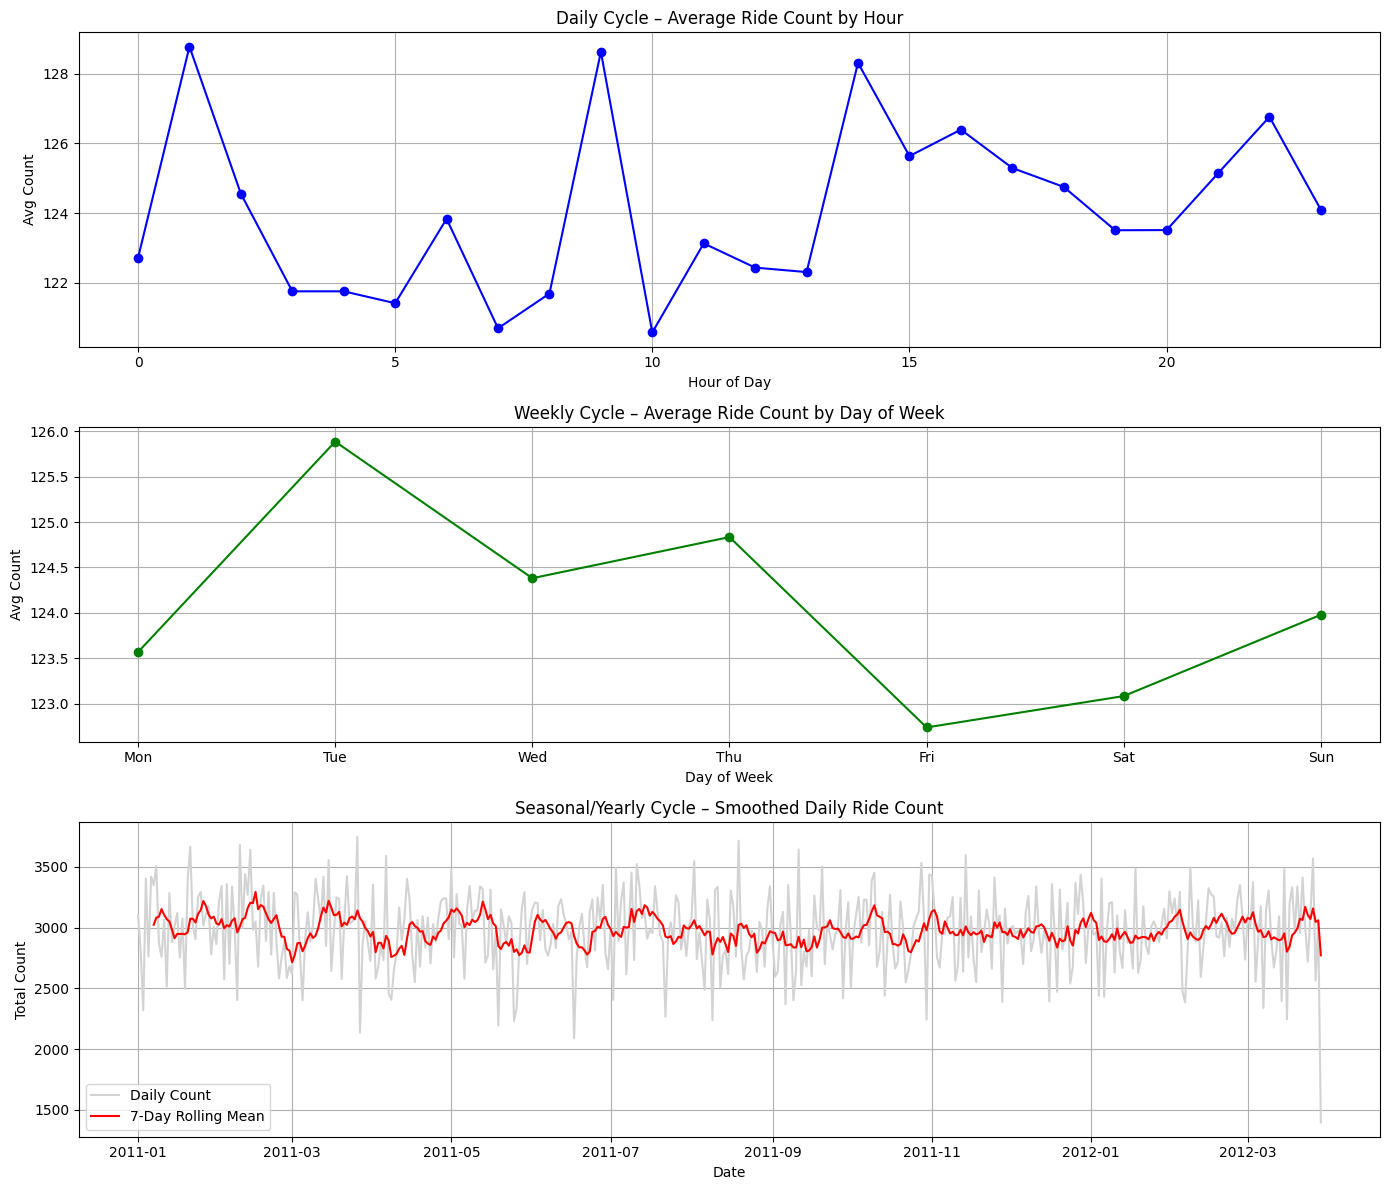

In [ ]:



data['time'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
ts_data = data.set_index('time')


daily_cycle = ts_data.groupby(ts_data.index.hour)['count'].mean()


weekly_cycle = ts_data.groupby(ts_data.index.dayofweek)['count'].mean()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


daily_counts = ts_data['count'].resample('D').sum()
rolling_daily = daily_counts.rolling(window=7).mean()


fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=False)


axs[0].plot(daily_cycle.index, daily_cycle.values, marker='o', color='blue')
axs[0].set_title('Daily Cycle – Average Ride Count by Hour')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Avg Count')
axs[0].grid(True)


axs[1].plot(weekly_cycle.index, weekly_cycle.values, marker='o', color='green')
axs[1].set_title('Weekly Cycle – Average Ride Count by Day of Week')
axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Avg Count')
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(weekday_labels)
axs[1].grid(True)


axs[2].plot(daily_counts.index, daily_counts.values, color='lightgray', label='Daily Count')
axs[2].plot(rolling_daily.index, rolling_daily.values, color='red', label='7-Day Rolling Mean')
axs[2].set_title('Seasonal/Yearly Cycle – Smoothed Daily Rlside Count')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Total Count')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


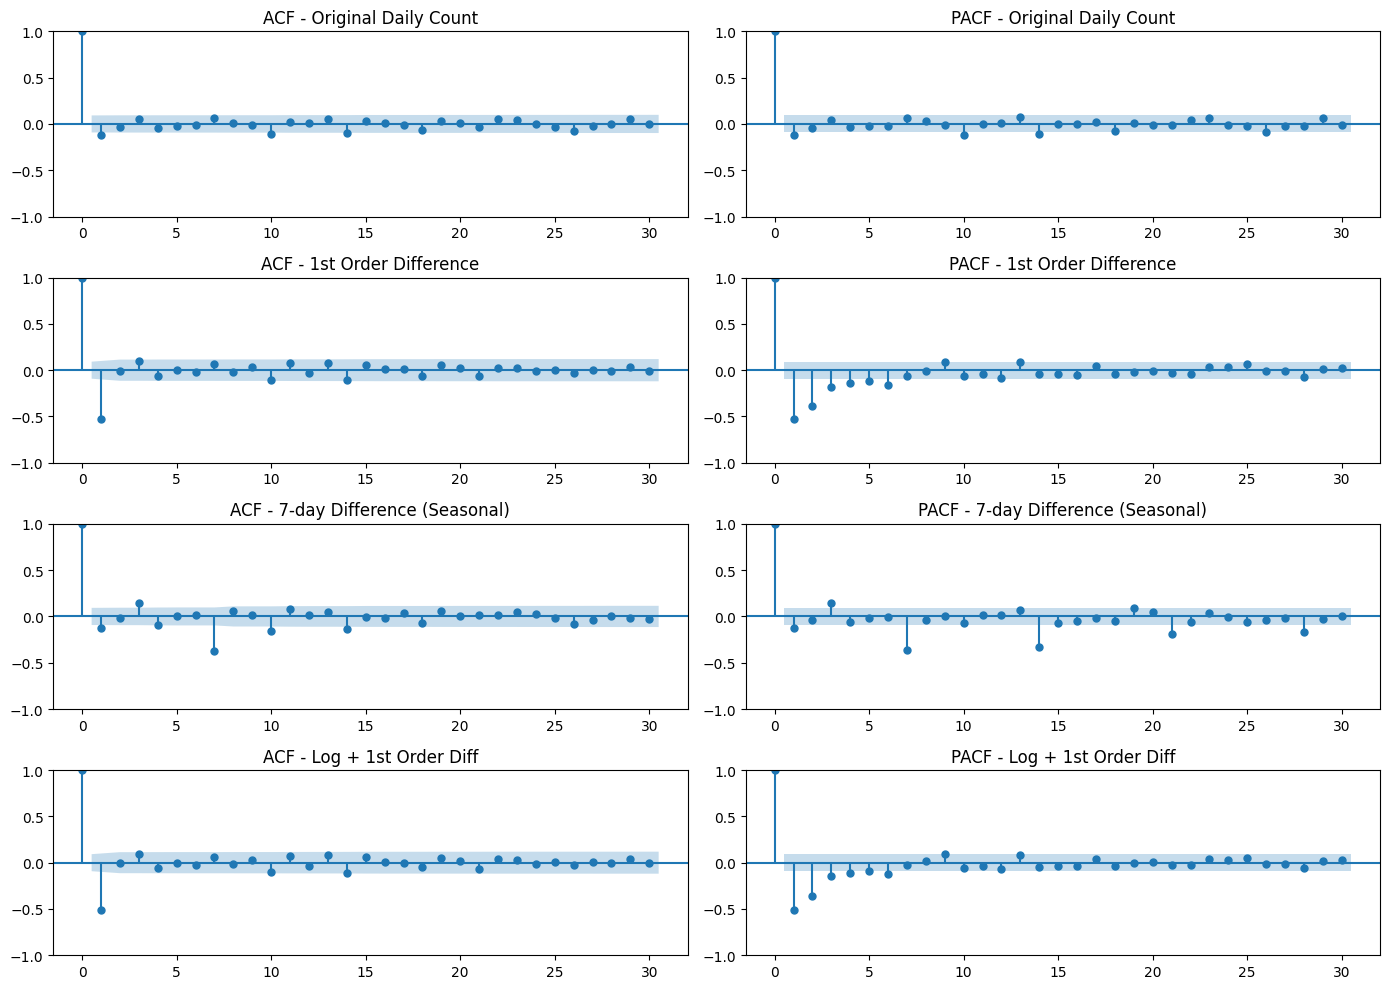

In [49]:
 
daily_counts = ts_data['count'].resample('D').sum().dropna()
diff_1 = daily_counts.diff().dropna()
diff_7 = daily_counts.diff(7).dropna()
log_diff = np.log1p(daily_counts).diff().dropna()

series_list = [
    ('Original Daily Count', daily_counts),
    ('1st Order Difference', diff_1),
    ('7-day Difference (Seasonal)', diff_7),
    ('Log + 1st Order Diff', log_diff)
]


fig, axs = plt.subplots(len(series_list), 2, figsize=(14, 10))

for i, (title, series) in enumerate(series_list):
    plot_acf(series, lags=30, ax=axs[i, 0])
    axs[i, 0].set_title(f'ACF - {title}')
    plot_pacf(series, lags=30, ax=axs[i, 1])
    axs[i, 1].set_title(f'PACF - {title}')

plt.tight_layout()
plt.show()


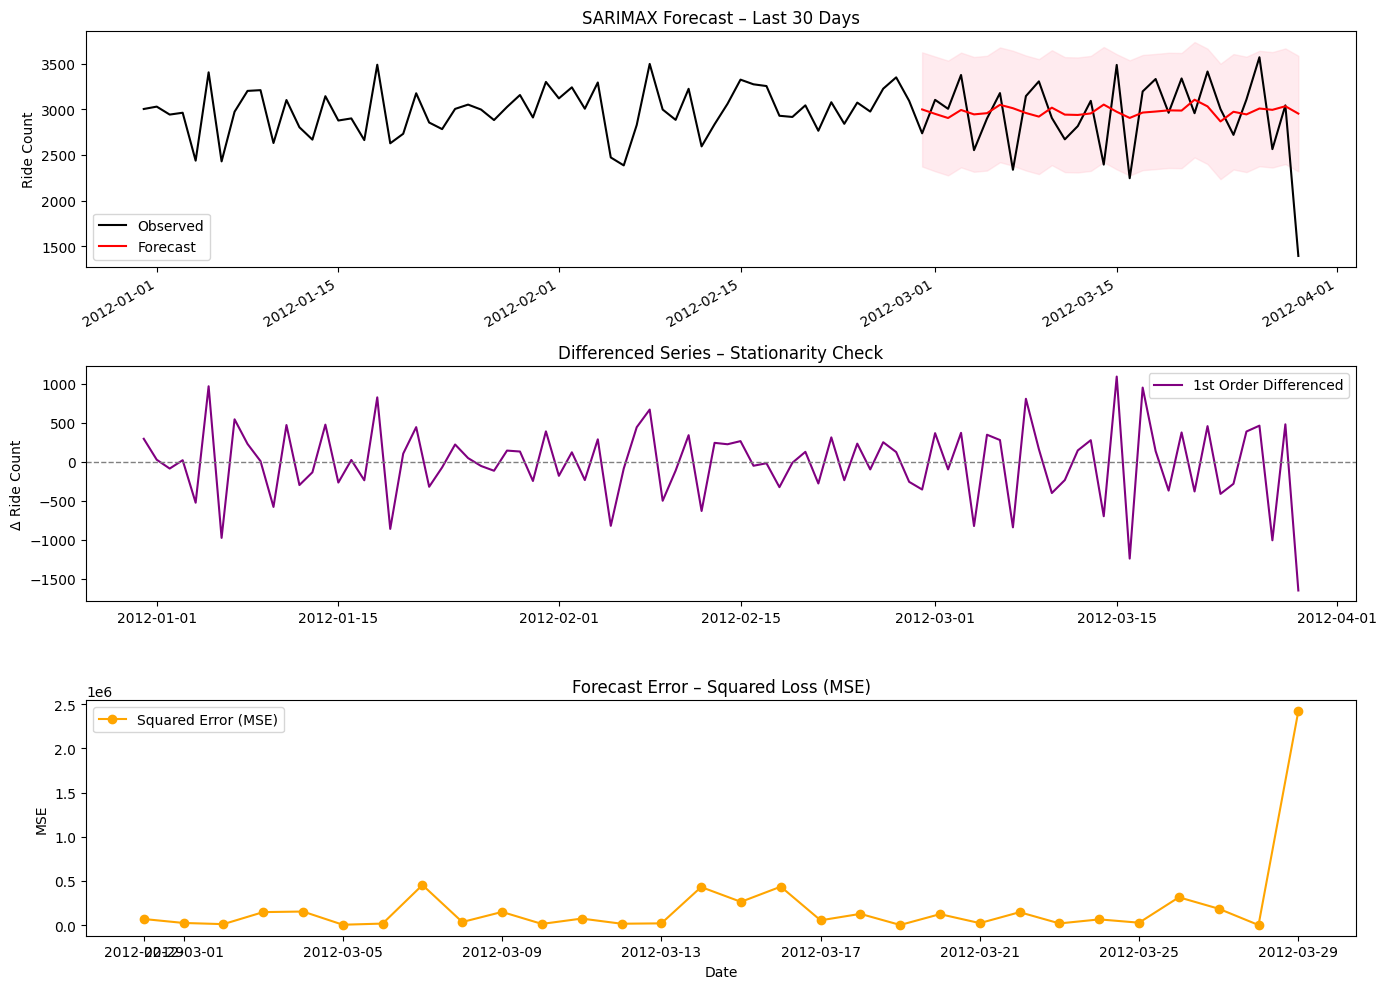

In [ ]:



daily_counts = ts_data['count'].resample('D').sum().dropna()

exog_vars = ts_data[['temp', 'humidity', 'windspeed', 'weather', 'season']]
daily_exog = exog_vars.resample('D').mean().fillna(method='ffill')


exog_train = daily_exog.iloc[:-30]
exog_test = daily_exog.iloc[-30:]

train = daily_counts[:-30]
test = daily_counts[-30:]


model = SARIMAX(
    train,
    exog=exog_train,    order=(1, 1, 1),
   seasonal_order=(0, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)


forecast = results.get_forecast(steps=30 , exog = exog_test)
forecast_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()


mse_loss = (test - forecast_mean)**2


differenced = daily_counts.diff().dropna()


fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)


axes[0].plot(daily_counts[-90:], label='Observed', color='black')
forecast_mean.plot(ax=axes[0], label='Forecast', color='red')
axes[0].fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                     color='pink', alpha=0.3)
axes[0].set_title('SARIMAX Forecast – Last 30 Days')
axes[0].set_ylabel('Ride Count')
axes[0].legend()


axes[1].plot(differenced[-90:], color='purple', label='1st Order Differenced')
axes[1].axhline(0, linestyle='--', color='gray', linewidth=1)
axes[1].set_title('Differenced Series – Stationarity Check')
axes[1].set_ylabel('Δ Ride Count')
axes[1].legend()


axes[2].plot(mse_loss.index, mse_loss.values, color='orange', marker='o', label='Squared Error (MSE)')
axes[2].set_title('Forecast Error – Squared Loss (MSE)')
axes[2].set_ylabel('MSE')
axes[2].set_xlabel('Date')
axes[2].legend()

plt.tight_layout()
plt.show()


## SARIMAX with RF

Hybrid Model MSE: 465317.33
SARIMAX-only MSE: 198026.97


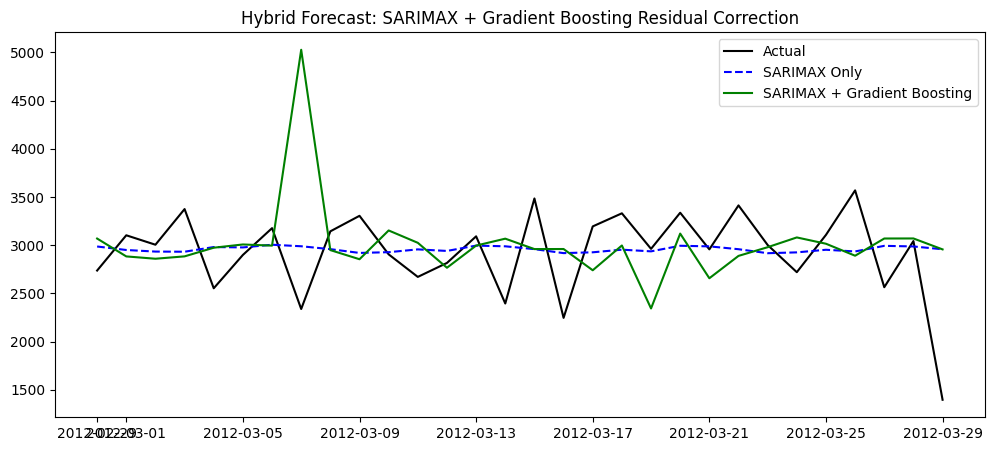

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


daily_counts = ts_data['count'].resample('D').sum().dropna()


train = daily_counts[:-30]
test = daily_counts[-30:]


model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=False)


sarimax_fitted = results.fittedvalues


residuals = train - sarimax_fitted


exog_vars = ts_data[['temp', 'humidity', 'windspeed', 'weather', 'season']]
daily_exog = exog_vars.resample('D').mean().fillna(method='ffill')


X_gb = daily_exog.loc[residuals.index]
y_gb = residuals


gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_gb, y_gb)


X_test_gb = daily_exog.loc[test.index]
residual_preds = gb.predict(X_test_gb)


forecast = results.get_forecast(steps=30)
sarimax_forecast = forecast.predicted_mean


final_forecast = sarimax_forecast + residual_preds


hybrid_mse = mean_squared_error(test, final_forecast)
print(f"Hybrid Model MSE: {hybrid_mse:.2f}")


sarimax_mse = mean_squared_error(test, sarimax_forecast)
print(f"SARIMAX-only MSE: {sarimax_mse:.2f}")


plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Only', color='blue', linestyle='--')
plt.plot(test.index, final_forecast, label='SARIMAX + Gradient Boosting', color='green')
plt.legend()
plt.title('Hybrid Forecast: SARIMAX + Gradient Boosting Residual Correction')
plt.show()


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam


model = Sequential()


model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1))))
model.add(Dropout(0.2))  


model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))


model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(units=1))


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.2260 - val_loss: 0.0210
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0327 - val_loss: 0.0210
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0258 - val_loss: 0.0216
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0258 - val_loss: 0.0212
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0220 - val_loss: 0.0210
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0244 - val_loss: 0.0212
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0210 - val_loss: 0.0210
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0225 - val_loss: 0.0224
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0232 - val_loss: 0.0209
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


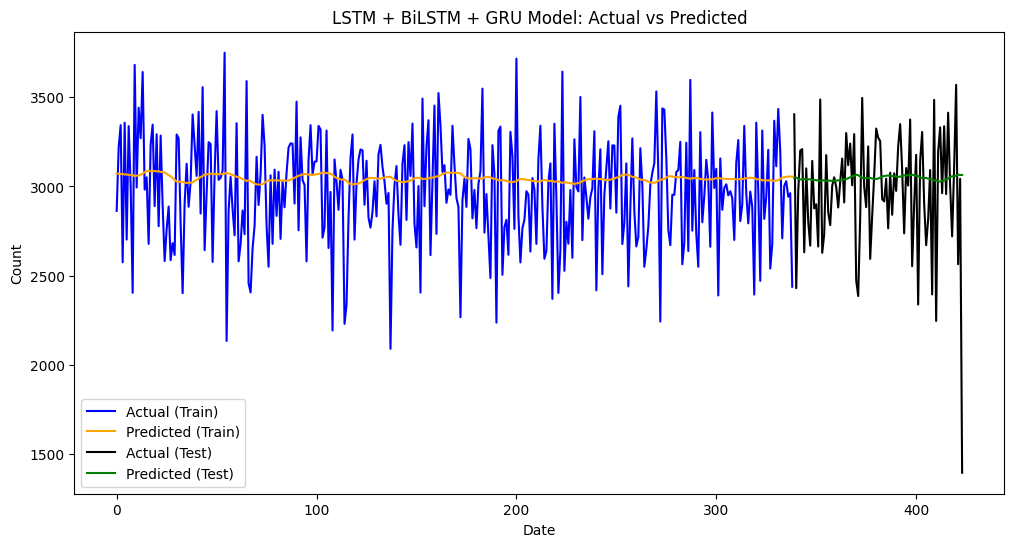

In [53]:

train_predict = model.predict(X_train)

test_predict = model.predict(X_test)


train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])


plt.figure(figsize=(12, 6))


plt.plot(data.index[:train_size], y_train_actual[0], label='Actual (Train)', color='blue')


plt.plot(data.index[:train_size], train_predict[:, 0], label='Predicted (Train)', color='orange')


plt.plot(data.index[train_size:train_size+len(y_test_actual[0])], y_test_actual[0], label='Actual (Test)', color='black')


plt.plot(data.index[train_size:train_size+len(test_predict)], test_predict[:, 0], label='Predicted (Test)', color='green')


plt.xlabel('Date')
plt.ylabel('Count')
plt.title('LSTM + BiLSTM + GRU Model: Actual vs Predicted')
plt.legend()


plt.show()
